<a href="https://colab.research.google.com/github/antonellagambarte/proyecto-final-CEIA/blob/main/LIMPIEZA_DATASET_NHANES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [11]:
# Leer el archivo
ruta_archivo = '/content/drive/My Drive/NHANES/df_min.csv'
df = pd.read_csv(ruta_archivo)

# Verificar que los datos llegaron bien
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_paciente                             5568 non-null   float64
 1   tipo_entrevista                         5568 non-null   float64
 2   edad                                    5568 non-null   float64
 3   genero                                  5568 non-null   float64
 4   presion_sis_1                           4658 non-null   float64
 5   presion_sis_2                           4885 non-null   float64
 6   presion_sis_3                           4872 non-null   float64
 7   colesterol_total                        4936 non-null   float64
 8   hdl                                     4936 non-null   float64
 9   ldl                                     2368 non-null   float64
 10  trigliceridos                           2393 non-null   floa

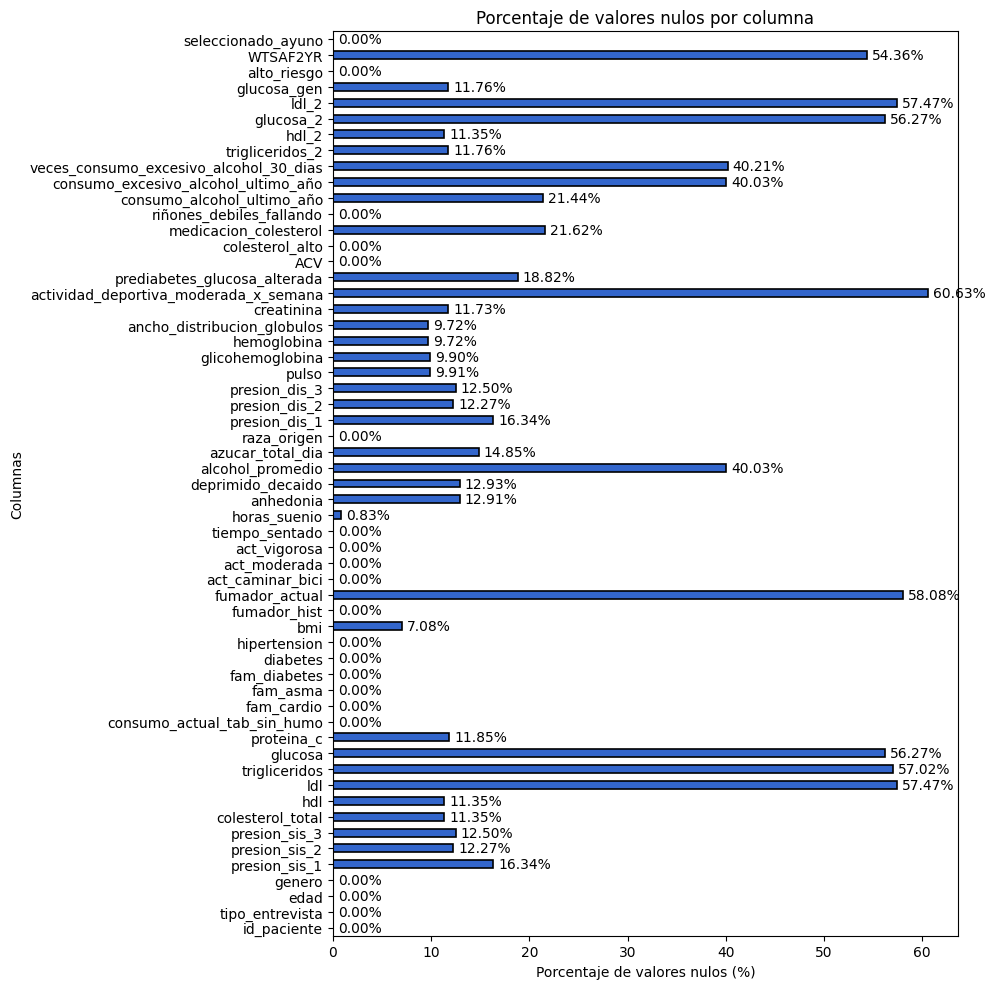

In [12]:
porcentaje_nulos = df.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

### **BMI**

In [18]:
print("--- PERFIL DE NULOS EN BMI ---")

# 1. ¿Cuántos nulos hay realmente?
total_nulos_bmi = df['bmi'].isnull().sum()
print(f"Total nulos: {total_nulos_bmi} ({ (total_nulos_bmi/len(df))*100 :.2f}%)")

# 2. ¿Hay sesgo de género?
print("\nDistribución por Género en nulos de BMI:")
print(df[df['bmi'].isnull()]['genero'].value_counts(normalize=True))

# 3. ¿Hay sesgo por Edad?
print("\nEdad promedio de los nulos:")
print(df[df['bmi'].isnull()]['edad'].mean())
print("Edad promedio de los NO nulos:")
print(df[df['bmi'].notnull()]['edad'].mean())

# 4. ¿Están relacionados con los nulos de presión?
ambos_nulos = df[df['bmi'].isnull() & df['presion_sistolica_final'].isnull()].shape[0]
print(f"\nPacientes que no tienen NI presión NI BMI: {ambos_nulos}")

--- PERFIL DE NULOS EN BMI ---
Total nulos: 394 (7.08%)

Distribución por Género en nulos de BMI:
genero
1.0    0.530457
2.0    0.469543
Name: proportion, dtype: float64

Edad promedio de los nulos:
54.9263959390863
Edad promedio de los NO nulos:
51.24101275608813

Pacientes que no tienen NI presión NI BMI: 330


Imputación con mediana por rango de edad

In [19]:
# 1. Crear el rango de edad (décadas) para que la imputación sea biológicamente coherente
df['rango_edad'] = (df['edad'] // 10) * 10

# 2. Realizar la imputación por estratos
# Esto asigna la mediana de BMI de personas del mismo sexo y rango de edad
df['bmi'] = df.groupby(['genero', 'rango_edad'])['bmi'].transform(lambda x: x.fillna(x.median()))

# 3. Red de seguridad
# Por si existe algún grupo demográfico sin ningún dato (muy poco probable en NHANES)
if df['bmi'].isnull().any():
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())

print("--- VERIFICACIÓN DE BMI ---")
print(f"Nulos restantes en BMI: {df['bmi'].isnull().sum()}")
print(f"Estadísticas del BMI post-imputación:\n{df['bmi'].describe()}")

--- VERIFICACIÓN DE BMI ---
Nulos restantes en BMI: 0
Estadísticas del BMI post-imputación:
count    5568.000000
mean       29.750108
std         7.142021
min        14.200000
25%        25.100000
50%        28.600000
75%        33.100000
max        86.200000
Name: bmi, dtype: float64


### **PRESION**

En este caso, se tienen 3 medidas. Primero, para cada fila, vamos a hacer el promedio de los valores que se tengan para que obtengamos una sola columna con los valores de presion sistolica y otra distolica.

In [21]:
# 1. Definimos las columnas de presión según tu nueva lista
cols_sis = ['presion_sis_1', 'presion_sis_2', 'presion_sis_3']
cols_dis = ['presion_dis_1', 'presion_dis_2', 'presion_dis_3']

# 2. Creamos la medida final (promedio de las que NO son NaN)
df['presion_sistolica_final'] = df[cols_sis].mean(axis=1)
df['presion_diastolica_final'] = df[cols_dis].mean(axis=1)

# 3. Auditoría de rescate
nulos_antes = df['presion_sis_1'].isnull().sum()
nulos_despues = df['presion_sistolica_final'].isnull().sum()

print(f"Nulos originales en 'presion_sis_1': {nulos_antes}")
print(f"Nulos finales tras el rescate: {nulos_despues}")
print(f"¡Logramos recuperar {nulos_antes - nulos_despues} pacientes!")

Nulos originales en 'presion_sis_1': 910
Nulos finales tras el rescate: 573
¡Logramos recuperar 337 pacientes!


In [22]:
# Comparamos la edad media de los que tienen presión vs los que no
print("--- COMPARATIVA DE NULOS DE PRESIÓN ---")
print("Edad promedio con presión:")
print(df[df['presion_sistolica_final'].notnull()]['edad'].mean())

print("\nEdad promedio de los nulos:")
print(df[df['presion_sistolica_final'].isnull()]['edad'].mean())

--- COMPARATIVA DE NULOS DE PRESIÓN ---
Edad promedio con presión:
51.44244244244244

Edad promedio de los nulos:
52.019197207678886


Se compara la imputación con mediana por rango de edad e imputacion con knn

In [23]:
# Creamos copias para comparar
df_mediana = df.copy()
df_knn = df.copy()

# --- PRUEBA OPCIÓN 2: Mediana por Grupos de Edad ---
df_mediana['rango_edad'] = (df_mediana['edad'] // 10) * 10
df_mediana['presion_sistolica_final'] = df_mediana.groupby('rango_edad')['presion_sistolica_final'].transform(lambda x: x.fillna(x.median()))

# --- PRUEBA OPCIÓN 3: KNN (Usando variables clave) ---
# Seleccionamos columnas que ayudan a predecir (deben ser numéricas y sin nulos si es posible)
cols_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final']
imputer = KNNImputer(n_neighbors=5)
# Solo imputamos en la copia
df_knn[cols_knn] = imputer.fit_transform(df_knn[cols_knn])

# --- COMPARACIÓN DE RESULTADOS ---
print("ESTADÍSTICAS DE PRESIÓN SISTÓLICA")
print(f"Original (con nulos): Media {df['presion_sistolica_final'].mean():.2f}, Desv. Est. {df['presion_sistolica_final'].std():.2f}")
print(f"Post Mediana Grupos:  Media {df_mediana['presion_sistolica_final'].mean():.2f}, Desv. Est. {df_mediana['presion_sistolica_final'].std():.2f}")
print(f"Post KNN:             Media {df_knn['presion_sistolica_final'].mean():.2f}, Desv. Est. {df_knn['presion_sistolica_final'].std():.2f}")

ESTADÍSTICAS DE PRESIÓN SISTÓLICA
Original (con nulos): Media 127.13, Desv. Est. 20.17
Post Mediana Grupos:  Media 126.99, Desv. Est. 19.37
Post KNN:             Media 127.18, Desv. Est. 19.62


KNN es mas cercano a la desviación estandar antes de imputar, asi que se utiliza knn

In [24]:
# 1. Primero aseguramos un BMI básico (mediana) para que no rompa el KNN
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# 2. Definimos las columnas que "se ayudan" entre sí
# Incluimos variables que tienen relación biológica con la presión
cols_para_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final', 'presion_diastolica_final']

imputer = KNNImputer(n_neighbors=5)

# 3. Aplicamos la imputación
df[cols_para_knn] = imputer.fit_transform(df[cols_para_knn])

# 4. Verificación final
print(f"Nulos restantes en Sistólica Final: {df['presion_sistolica_final'].isnull().sum()}")
print(f"Nulos restantes en Diastólica Final: {df['presion_diastolica_final'].isnull().sum()}")

Nulos restantes en Sistólica Final: 0
Nulos restantes en Diastólica Final: 0


Borro columnas de presion

In [26]:
# Lista de columnas que ya procesamos y consolidamos
columnas_a_eliminar = [
    'presion_sis_1', 'presion_sis_2', 'presion_sis_3',
    'presion_dis_1', 'presion_dis_2', 'presion_dis_3',
    'rango_edad' # Esta la creamos solo para la imputación
]

# Las eliminamos
df.drop(columns=columnas_a_eliminar, inplace=True)

print("--- LIMPIEZA DE COLUMNAS COMPLETADA ---")
print(f"Columnas restantes: {len(df.columns)}")

--- LIMPIEZA DE COLUMNAS COMPLETADA ---
Columnas restantes: 53


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_paciente                             5568 non-null   float64
 1   tipo_entrevista                         5568 non-null   float64
 2   edad                                    5568 non-null   float64
 3   genero                                  5568 non-null   float64
 4   colesterol_total                        4936 non-null   float64
 5   hdl                                     4936 non-null   float64
 6   ldl                                     2368 non-null   float64
 7   trigliceridos                           2393 non-null   float64
 8   glucosa                                 2435 non-null   float64
 9   proteina_c                              4908 non-null   float64
 10  consumo_actual_tab_sin_humo             5568 non-null   floa

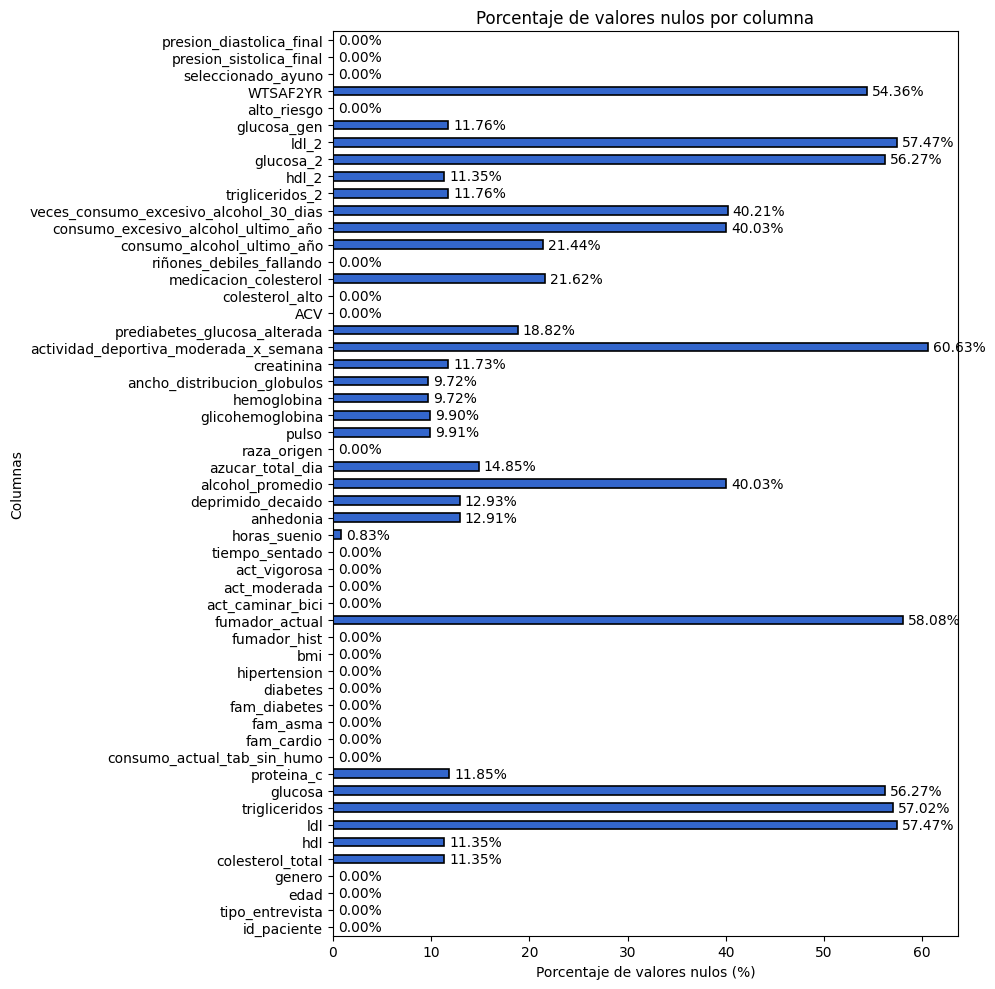

In [28]:
porcentaje_nulos = df.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()